Functions

In [144]:
import pandas as pd
import numpy as np
import umap
import numpy as np
import sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import umap.plot
import GEOparse
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from scipy.stats import zscore

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage



# import warnings
# warnings.filterwarnings("ignore")

In [152]:
######################################################
def pca_analysis(df, n_comp=None, standardize=None):
    #1. Calculate PCA Dataframe and Agg statistics
    pca_df = df.copy()
    pca_df = pca_df.dropna().reset_index(drop=True)

    #create data object based on full df
    data_df = pca_df.drop(['cell_id', 'zone'], axis=1).copy()    
    data_df = data_df.astype(float)
    cols    = data_df.columns
    x       = data_df.loc[:, ].values #make sure only data columns are being passed

    #normalizes data to z scores
    if standardize == 'log': 
        x = np.nan_to_num(x, nan=0, posinf=0, neginf=0)
        x = np.log(x)
        x = np.nan_to_num(x, nan=0, posinf=0, neginf=0)
    elif standardize == 'zscore':
        x = zscore(x)
        x = np.nan_to_num(x, nan=0, posinf=0, neginf=0)
    else:   
        x = StandardScaler().fit_transform(x)
    
    scaled_df = pd.DataFrame(data = x, columns = cols)

    pca = PCA(n_components = n_comp)
    principalComponents = pca.fit_transform(x) #Xnew
    print(f'pca.explained_variance_ratio: \t{pca.explained_variance_ratio_}')

    #adjust pc_cols
    pc_cols = ['PC' + str(f+1) for f in range(n_comp)]
    
    #creates dataframe from pca results
    principalDf = pd.DataFrame(data = principalComponents
                , columns = pc_cols)

    #df of pca analysis and potential clustering categories
    finalDf = pd.concat([principalDf, df[['cell_id', 'zone']]], axis = 1) # add additional cluster categories here

    print(f'number of genes: {len(df.columns)}')
    print(f'number of cells: {len(df)}')
    #create plot
    plot_pca(finalDf, n_comp=n_comp, standardized=standardize)
    
    return finalDf
######################################################
def plot_pca(df, n_comp=None, standardized=None):
    pca_df = df.copy()
    pca_df = pca_df.sort_values('zone').reset_index(drop=True)
    if standardized == None: 
        standardized = 'Standardized'
    elif standardized == 'log': 
        standardized = 'Log Transformed'
    elif standardized == 'zscore':
        standardized = "Z Transformed"
    if n_comp == 3:
        ## Basic Plot ##
        # create a 3D scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'])

        # add labels to the plot
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
            # show the plot
        plt.show()

        # create a plotly figure
        fig = go.Figure()

        # add a 3D scatter plot
        fig.add_trace(go.Scatter3d(
            x=pca_df['PC1'], y=pca_df['PC2'], z=pca_df['PC3'],
            mode='markers',
            marker=dict(
                size=5,
                color=pca_df['PC3'],
                colorscale='Viridis',
                opacity=0.8
            )
        ))

        # add axes labels and title
        fig.update_layout(
            scene=dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3',
                aspectmode='cube',
            ),
            title='3D PCA Plot'
        )

        # show the figure
        fig.show()
    elif n_comp == 2: 
        # create 2 d scatter plot of pca
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='zone', legend='auto', palette='Blues')
        
        plt.title(f'2 Component PCA using {standardized} data')
        plt.show()
######################################################
def load_rnaseq():
    # load table B
    rnaseq = pd.read_csv("./table_B_scRNAseq_UMI_counts.tsv", sep='\t')
    #sort top ~7531 genes
    rnaseq['total'] = rnaseq.sum(axis=1)

    rnaseq = rnaseq[rnaseq['total'] > 80].reset_index(drop=True) 
    # approximates the top genes from the paper, 
    # potentially need to review STAR methods and adjust how this is done
    rnaseq = rnaseq.reset_index(drop=True).set_index('gene')
    rnaseq = rnaseq.drop(columns='total') #UMI is number of observed transcripts
    rnaseq = rnaseq.transpose().reset_index().rename({'index':'cell_id'}, axis=1)

    #add location data based on cells
    loc_df = pd.read_csv("./table_C_scRNAseq_tsne_coordinates_zones.tsv", sep='\t')

    rnaseq = pd.merge(rnaseq, loc_df[['cell_id', 'zone']], on='cell_id')
    rnaseq
    return rnaseq
######################################################
def apply_umap(df=None, n_comp=None):
    rnaseq = load_rnaseq()

    data_df = rnaseq.drop(['cell_id', 'zone'], axis=1).reset_index(drop=True)
    data_df = data_df.astype(float)

    # dists = [0.1, 0.2, 0.3, 0.5]
    # neighbors = [15, 25, 50, 75, 100]
    # for min_dist in dists:
    #     for n_neighbors in neighbors:
    #build model
    if n_comp == 2: 
        reducer = umap.UMAP(n_components=n_comp)
        scaler  = sklearn.preprocessing.StandardScaler()
        data    = scaler.fit_transform(data_df)

        #UMAP
        embedding        = reducer.fit(data)
        rnaseq_coord_df  = pd.DataFrame(embedding.embedding_, columns=['X','Y'])
        rnaseq['X']      = rnaseq_coord_df['X']
        rnaseq['Y']      = rnaseq_coord_df['Y']
        rnaseq['total']  = data_df.sum(axis=1)

        #create projeciton with location data
        umap.plot.points(embedding, labels=rnaseq['zone'])
        plt.title(f'UMAP of Top {rnaseq.shape[1]} Genes Colored by Location Data')
        plt.show()
    elif n_comp == 3: 
        # add 3-dimensional plotting
        reducer = umap.UMAP(n_components=n_comp)
        scaler  = sklearn.preprocessing.StandardScaler()
        data    = scaler.fit_transform(data_df)

        #UMAP
        embedding        = reducer.fit(data)
        rnaseq_coord_df  = pd.DataFrame(embedding.embedding_, columns=['X','Y','Z'])
        rnaseq['X']      = rnaseq_coord_df['X']
        rnaseq['Y']      = rnaseq_coord_df['Y']
        rnaseq['Z']      = rnaseq_coord_df['Z']
        rnaseq['total']  = data_df.sum(axis=1)


        ## Basic Plot ##
        # create a 3D scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(rnaseq['X'], rnaseq['Y'], rnaseq['Z'])

        # add labels to the plot
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
            # show the plot
        plt.show()

        # create a plotly figure
        fig = go.Figure()

        # add a 3D scatter plot
        fig.add_trace(go.Scatter3d(
            x=rnaseq['X'], y=rnaseq['Y'], z=rnaseq['Z'],
            mode='markers',
            marker=dict(
                size=5,
                color=rnaseq['Z'],
                colorscale='Viridis',
                opacity=0.8
            )
        ))

        # add axes labels and title
        fig.update_layout(
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
                aspectmode='cube',
            ),
            title='3D UMAP Plot'
        )

        # show the figure
        fig.show()

    return rnaseq
######################################################
def plot_tsne():
    import seaborn as sns
    tsne_df = pd.read_csv('./table_C_scRNAseq_tsne_coordinates_zones.tsv', sep='\t')
    tsne_df = tsne_df.sort_values('zone').reset_index(drop=True)

    # Set plot size
    plt.figure(figsize=(8, 6))

    # Create scatterplot
    sns.scatterplot(data=tsne_df, x='tSNE_coordinate_1', y='tSNE_coordinate_2', hue='zone', palette='Blues')

    # Set plot title
    plt.title(f'Recreation of tSNE plot for Single Cell Sequencing')

    # Adjust legend position and fontsize
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)
    plt.show()
######################################################
######################################################
######################################################


In [71]:
################################################### UMAP #########################################################
def modded_k_means_umap_test(df, n_clusters_max):
  # Run the Kmeans algorithm and get the index of data points clusters
  km_df = df.copy()
  # Standardize the data
  # X_std = StandardScaler().fit_transform(km_df[['X', 'Y']])
  
  cols_to_drop = ['cell_id', 'zone', 'X', 'Y', 'total']
  X_std = StandardScaler().fit_transform(km_df.drop(cols_to_drop, axis=1))

  sse = []
  list_k = list(range(1, n_clusters_max))

  for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

  # Plot sse against k
  plt.figure(figsize=(6, 6))
  plt.plot(list_k, sse, '-o')
  plt.xlabel(r'Number of clusters *k*')
  plt.ylabel('Sum of squared distance')

  sil_vals = []
  for i, k in enumerate(range(2,n_clusters_max)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels    = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)
    sil_vals.append([k, silhouette_vals])
    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
      cluster_silhouette_vals = silhouette_vals[labels == cluster]
      cluster_silhouette_vals.sort()
      y_upper += len(cluster_silhouette_vals)
      ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
      ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
      y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02)
    
    print(labels)
    # Scatter plot of data colored with labels
    ax2.scatter(km_df['X'], km_df['Y'], c=labels)
    ax2.scatter(km_df['X'], km_df['Y'], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('UMAP_x')
    ax2.set_ylabel('UMAP_y')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
          fontsize=16, fontweight='semibold', y=1.05) 
##################################################################################################################
def set_kmeans(km_df, opt_clusters):
  km = KMeans(n_clusters=opt_clusters)
  new = km_df._get_numeric_data().dropna(axis=1)
  km.fit(new)
  predict=km.predict(new)

  km_df['kmeans'] = pd.Series(predict, index=km_df.index)
  km_df['kmeans'] = 'cluster_' + km_df['kmeans'].astype(str)
  km_df = km_df.sort_values(by='kmeans')
  km_df[['X', 'Y', 'kmeans']]
  return km_df
##################################################################################################################
def k_means_umap_test(df, n_clusters_max,  use_full=None):
  # Run the Kmeans algorithm and get the index of data points clusters
  km_df = df.copy()
  
  if use_full == None: 
    # Standardize the data
    X_std = StandardScaler().fit_transform(km_df[['X', 'Y']])
  else: 
    cols_to_drop = ['cell_id', 'zone', 'X', 'Y', 'total']
    X_std = StandardScaler().fit_transform(km_df.drop(cols_to_drop, axis=1))
    
  sse = []
  list_k = list(range(1, n_clusters_max))

  for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

  # Plot sse against k
  plt.figure(figsize=(6, 6))
  plt.plot(list_k, sse, '-o')
  plt.xlabel(r'Number of clusters *k*')
  plt.ylabel('Sum of squared distance')

  sil_vals = []
  for i, k in enumerate(range(2,n_clusters_max)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)
    sil_vals.append([k, silhouette_vals])
    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
      cluster_silhouette_vals = silhouette_vals[labels == cluster]
      cluster_silhouette_vals.sort()
      y_upper += len(cluster_silhouette_vals)
      ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
      ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
      y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02)
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels, )
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('UMAP_x')
    ax2.set_ylabel('UMAP_y')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
          fontsize=16, fontweight='semibold', y=1.05) 
##################################################################################################################
def set_hier(df, use_xy=None, max_cluster=None, label_n_clust=None):
  
  fc_df = df.copy()
  #hiearchical clustering
  if label_n_clust == None: 
    label_n_clust = 5

  cols_to_drop = ['cell_id', 'zone', 'X', 'Y', 'total']
  data = fc_df.drop(cols_to_drop, axis=1) # reduces to just the data columns

  if use_xy != None: 
    data = fc_df[['X', 'Y']].copy()

  linkage_data = linkage(data, method='ward', metric='euclidean')
  dendrogram(linkage_data)
  plt.show()

  if max_cluster != None:
    for nc in range(2, max_cluster):
      hierarchical_cluster = AgglomerativeClustering(n_clusters=nc, affinity='euclidean', linkage='ward')
      labels        = hierarchical_cluster.fit_predict(data)

      plt.scatter(x=fc_df['X'], y=fc_df['Y'], c=labels)
      plt.legend(labels)
      plt.title(f'{nc} clusters for UMAP projection')
      plt.show()
  if label_n_clust != None: 
    hierarchical_cluster = AgglomerativeClustering(n_clusters=label_n_clust, affinity='euclidean', linkage='ward')
    labels        = hierarchical_cluster.fit_predict(data)
    fc_df['hier_labels'] = labels
    fc_df['hier_labels'] = 'cluster_' + fc_df['hier_labels'].astype(str)
    fc_df = fc_df.sort_values(by='hier_labels')

    plt.scatter(x=fc_df['X'], y=fc_df['Y'], c=labels)
    plt.show()

  fc_df.reset_index(drop=True, inplace=True)
  return fc_df
##################################################################################################################


Determine total transcription of dataset

In [134]:
df = pd.read_csv("./table_B_scRNAseq_UMI_counts.tsv", sep='\t')
ttl_tr = df.drop('gene', axis=1).sum(axis=1).sum()
print(f'total number of transcripts across all cells for all genes: {ttl_tr}')
80/ttl_tr

total number of transcripts across all cells for all genes: 10804160


7.404555282409738e-06

# Step 1: Recreate Previous Work

### PCA 2 Components
fit_transform

pca.explained_variance_ratio: 	[0.14008157 0.03561615]
number of genes: 7518
number of cells: 1383


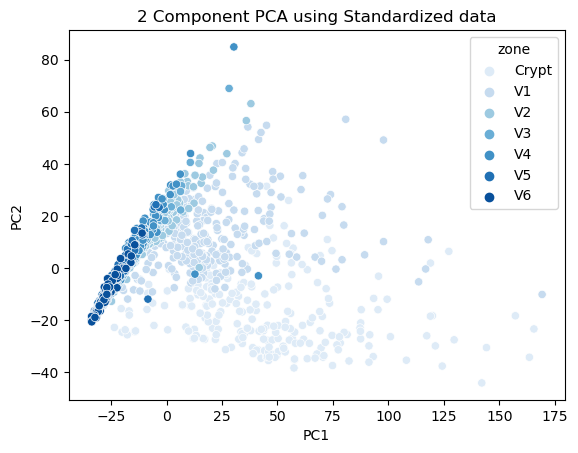

In [153]:
#Compare Python PCA to Rmd Document and troubleshoot
n_comp  = 2
rnaseq  = load_rnaseq()
finalDf = pca_analysis(rnaseq, n_comp=n_comp)

log transformed

pca.explained_variance_ratio: 	[0.40290961 0.09870609]
number of genes: 7518
number of cells: 1383


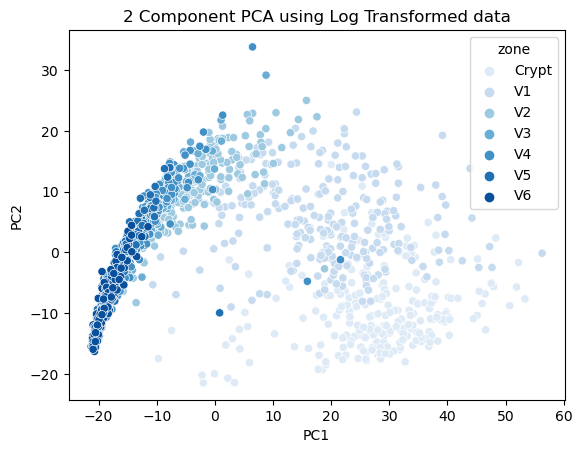

In [154]:
logDf = pca_analysis(rnaseq, n_comp=n_comp, standardize='log')


## tSNE

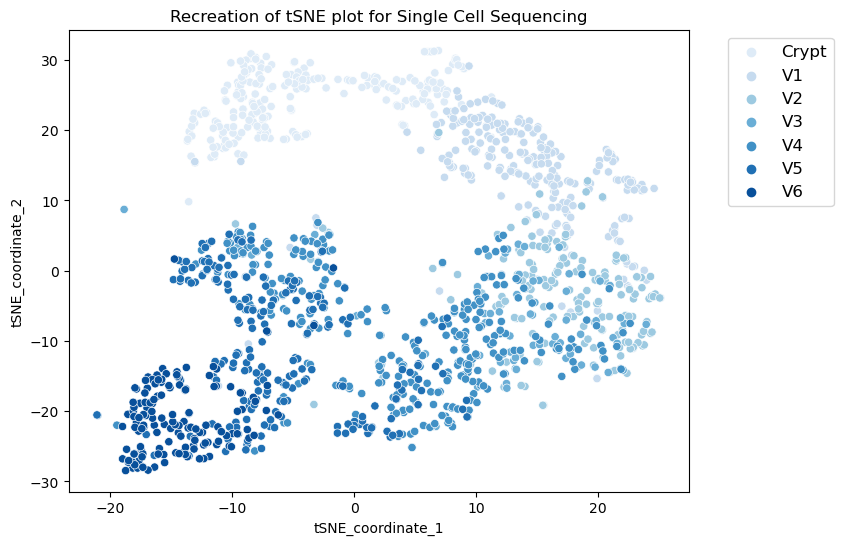

In [99]:
plot_tsne()

# Step 2: Apply UMAP and compare to previous Results

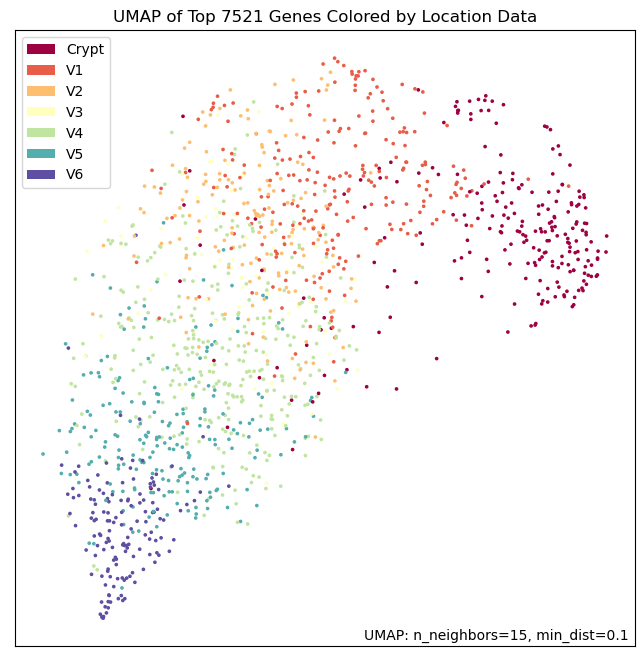

In [117]:
#Run this cell to generate the dataset
umap_coordinates = apply_umap(n_comp=2)

## How does this method differ from PCA, and what are the advantages

## Total Gene Expression

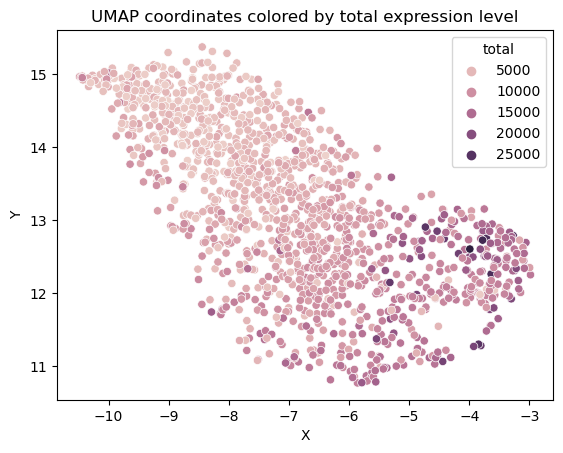

In [38]:
genes = ['total']
for gene in genes: 
    sns.scatterplot(data=umap_coordinates, x='X', y='Y', hue=gene)
    plt.title(f'UMAP coordinates colored by {gene} expression level')
    plt.show()

## Pick genes and view expression level

In [39]:
umap_coordinates
genes = umap_coordinates.columns
genes = genes.drop(['cell_id', 'zone', 'X', 'Y', 'total']) #keeps track of non gene columns
print([f for f in genes])


['Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1', 'Pcmtd1', 'Rrs1', 'Vcpip1', 'Snhg6', 'Cops5', 'Cspp1', 'Arfgef1', 'Ncoa2', 'Tram1', 'Lactb2', 'Xkr9', 'Terf1', 'Rpl7', 'Rdh10', 'Ube2w', 'Tceb1', 'Tmem70', 'Ly96', 'Mcm3', 'Smap1', 'Sdhaf4', 'Fam135a', 'Lmbrd1', 'Phf3', 'Ptp4a1', 'Zfp451', 'Dst', 'Ccdc115', 'Imp4', 'Ptpn18', 'Fam168b', 'Plekhb2', 'Hs6st1', 'Uggt1', 'Neurl3', 'Kansl3', 'Lman2l', 'Cnnm4', 'Cox5b', 'Actr1b', 'Tmem131', 'Inpp4a', 'Coa5', 'Unc50', 'Mgat4a', '2010300C02Rik', 'Mitd1', 'Mrpl30', 'Txndc9', 'Eif5b', 'Pdcl3', 'Npas2', 'Rpl31', 'Cnot11', 'Rnf149', 'Map4k4', 'Slc9a2', 'Mfsd9', 'Mrps9', 'Fhl2', 'Nck2', 'Uxs1', 'Tpp2', 'Tex30', 'Slc40a1', 'Stat1', 'Gls', 'Nab1', 'Mfsd6', 'Inpp1', 'Hibch', 'Ormdl1', 'Osgepl1', 'Asnsd1', 'Stk17b', 'Gtf3c3', 'Pgap1', 'Sf3b1', 'Coq10b', 'Hspd1', 'Hspe1', 'Mob4', '9430016H08Rik', 'Spats2l', 'Bzw1', 'Clk1', 'Ppil3', 'Nif3l1', 'Fam126b', 'Ndufb3', 'Cflar', 'Casp8', 'Trak2', 'Stradb', 'Sumo1', 'Nop58', 'Bmpr2', 'Fam117b', 'Wdr12', 'Nbeal1', 

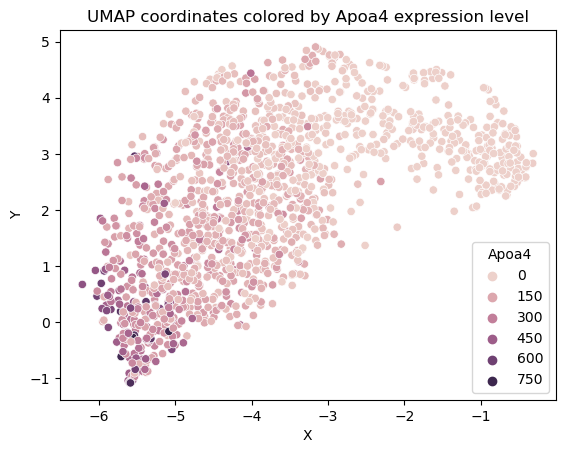

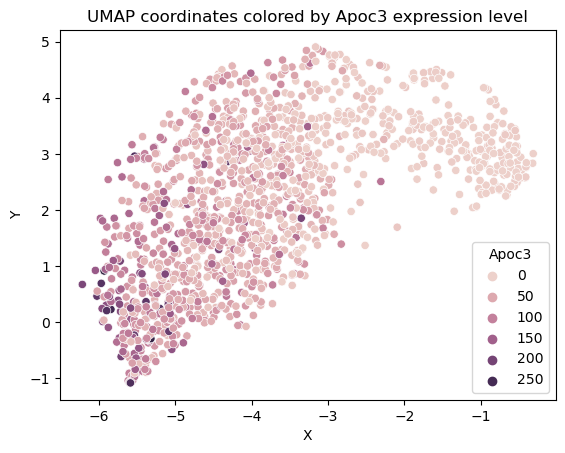

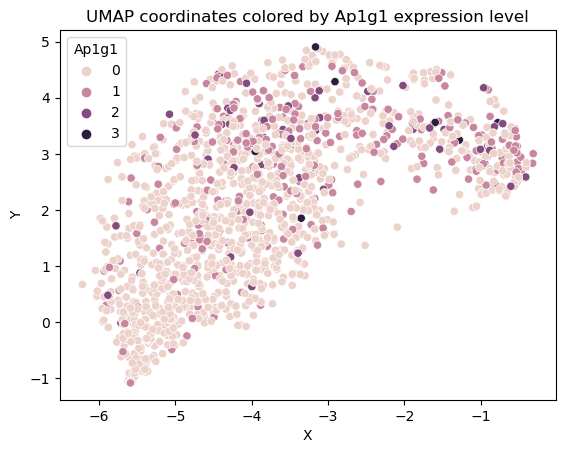

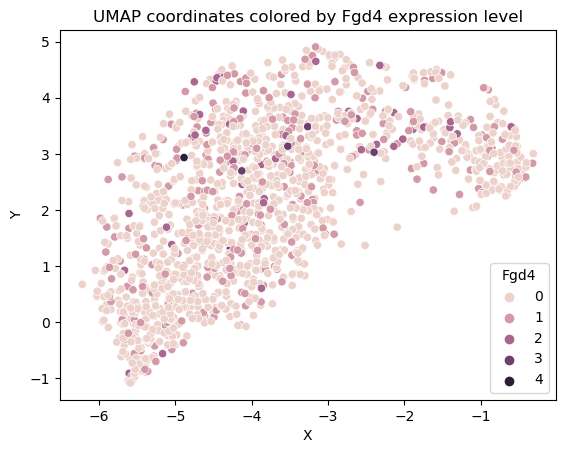

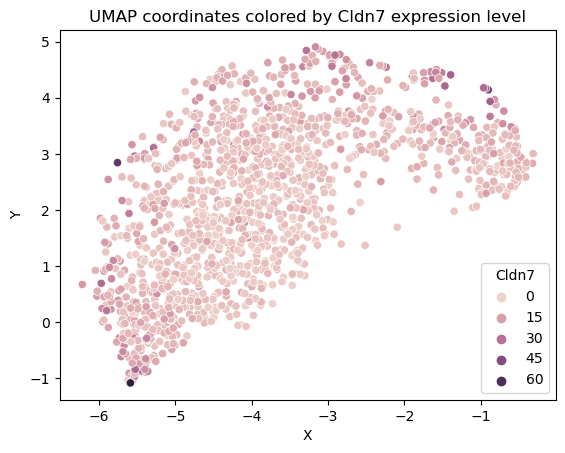

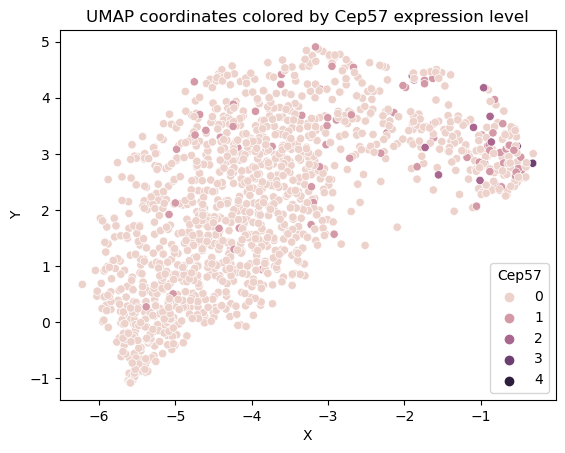

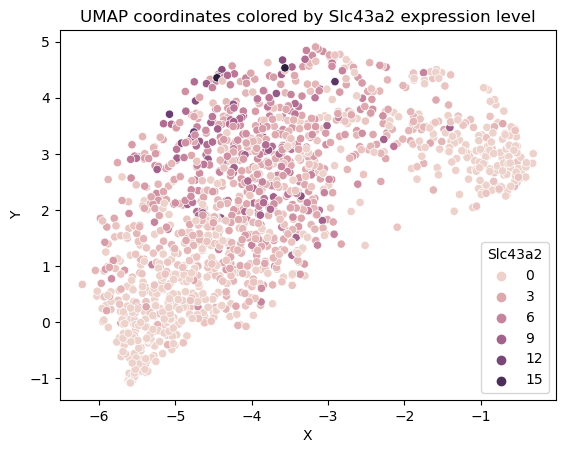

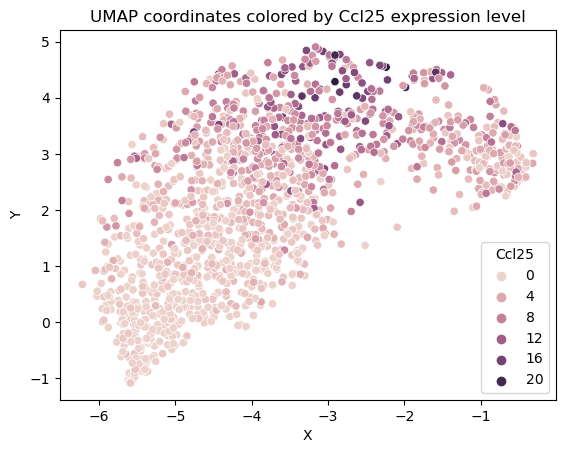

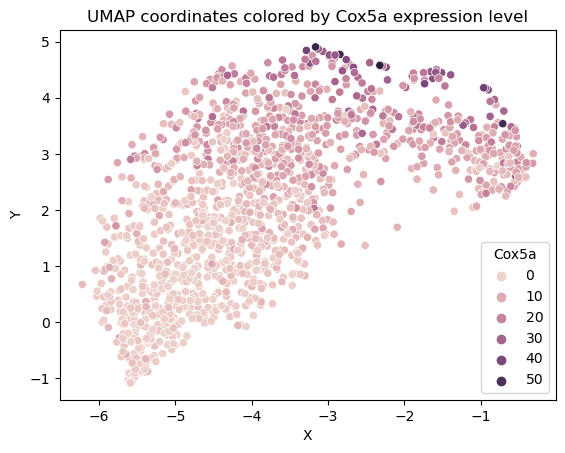

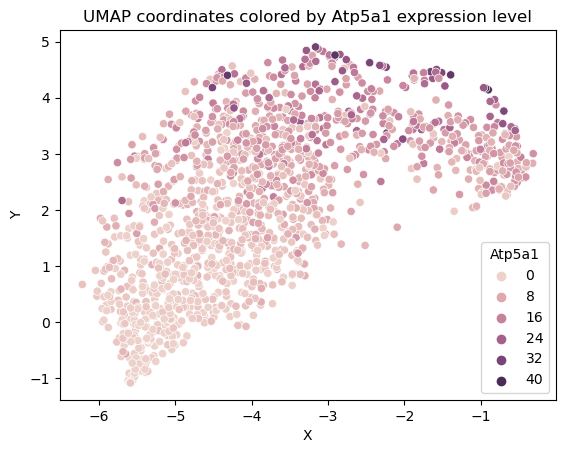

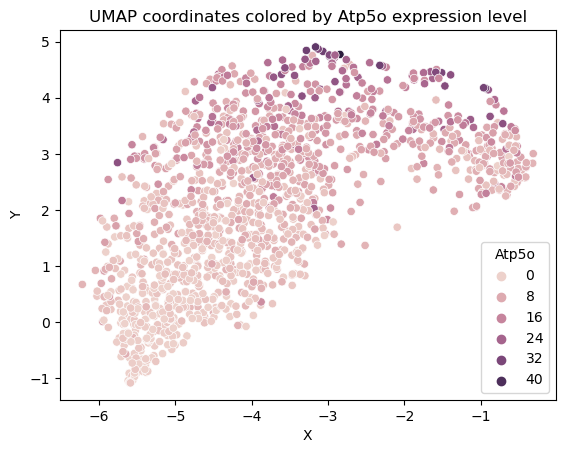

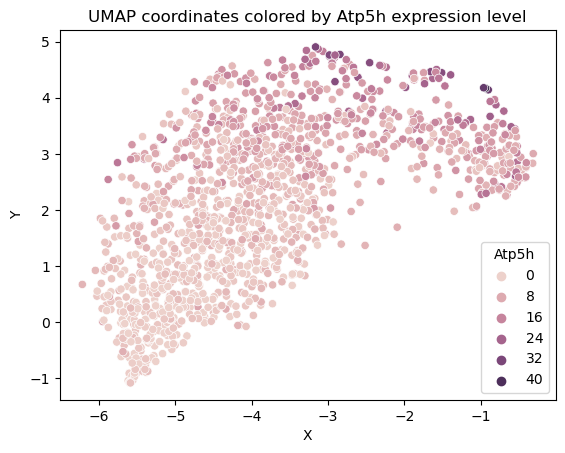

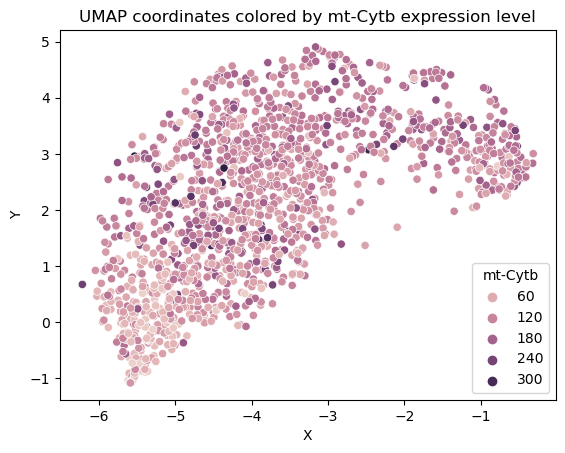

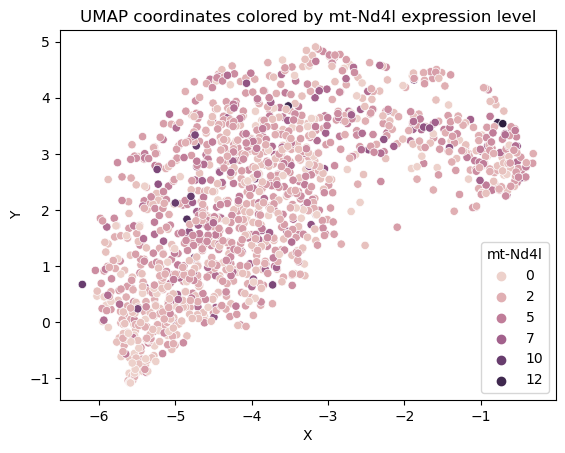

In [157]:
gs1 = ['Apoa4','Apoc3','Ap1g1', 'Fgd4', 'Cldn7', 'Cep57']
gs2 = ['Slc43a2']
gs3 = ['Ccl25', 'Cox5a','Atp5a1', 'Atp5o', 'Atp5h']
gs4 = ['mt-Cytb', 'mt-Nd4l'] 

genes_subset = gs1 + gs2 + gs3 + gs4

for gene in genes_subset: 
    sns.scatterplot(data=umap_coordinates, x='X', y='Y', hue=gene)
    plt.title(f'UMAP coordinates colored by {gene} expression level')
    plt.show()

## Apply Clustering

K-Means

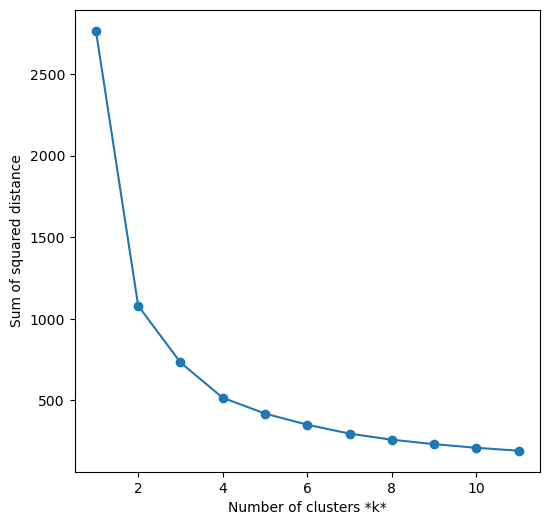

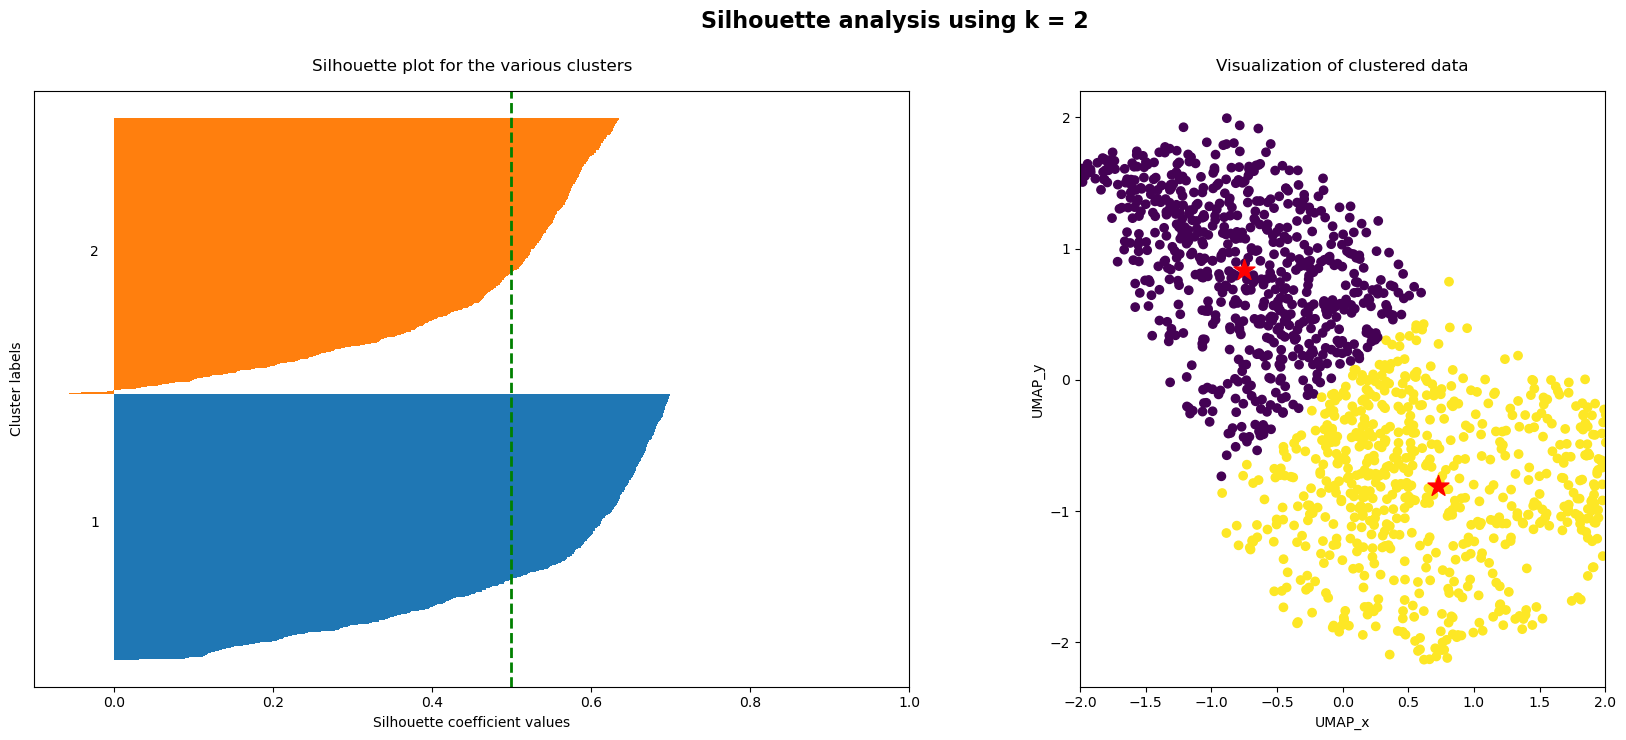

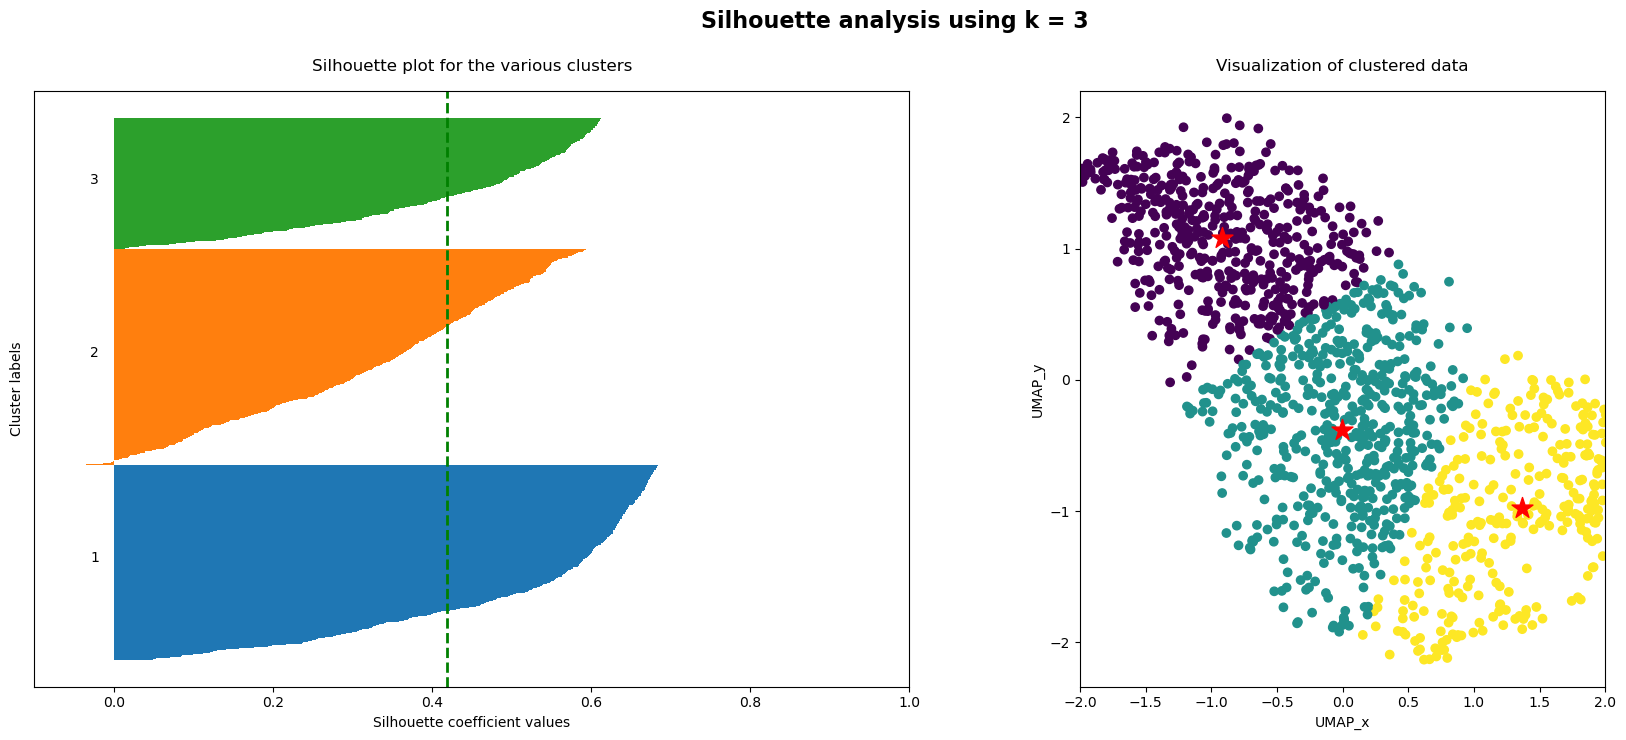

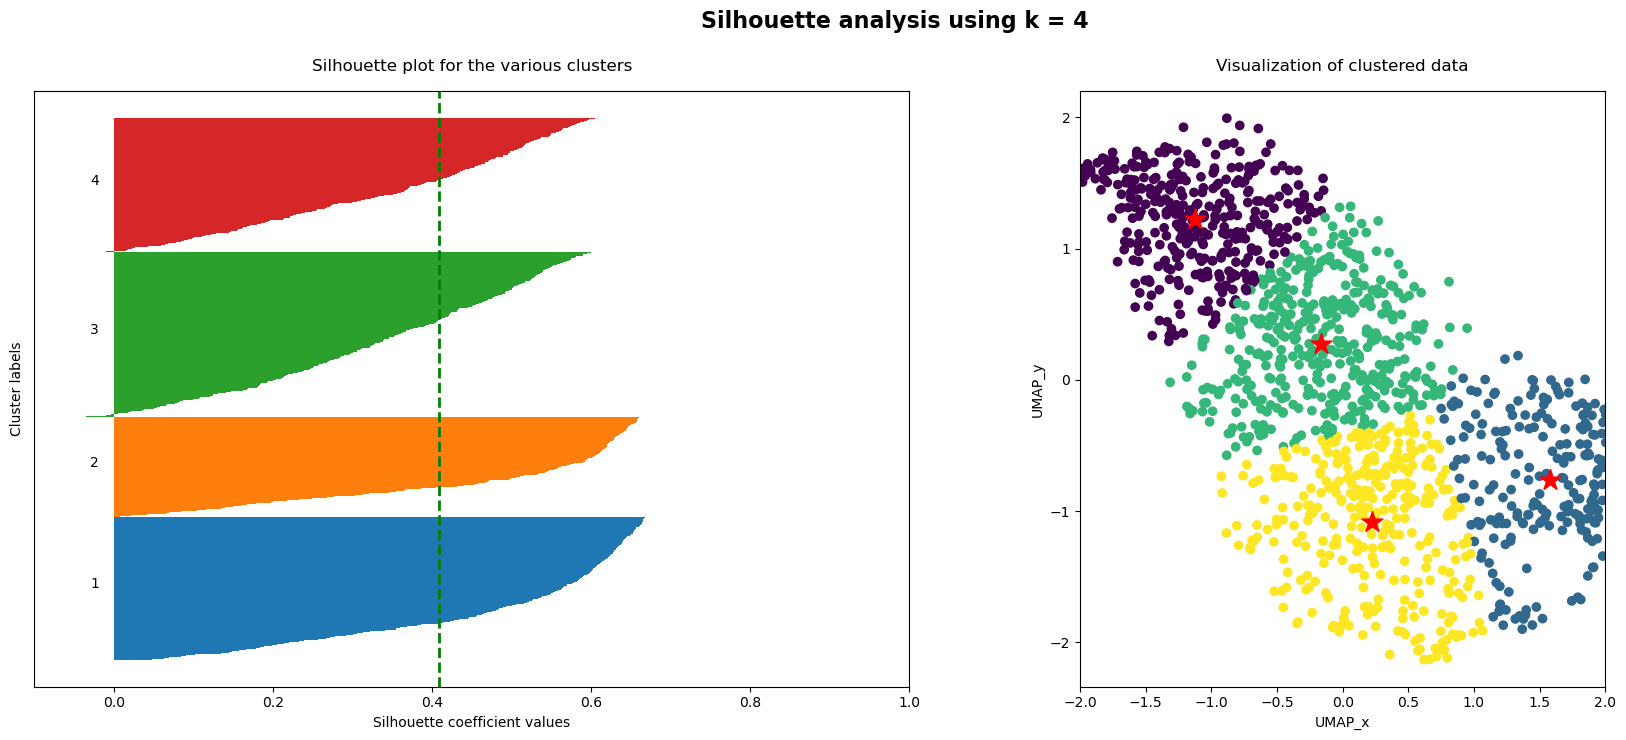

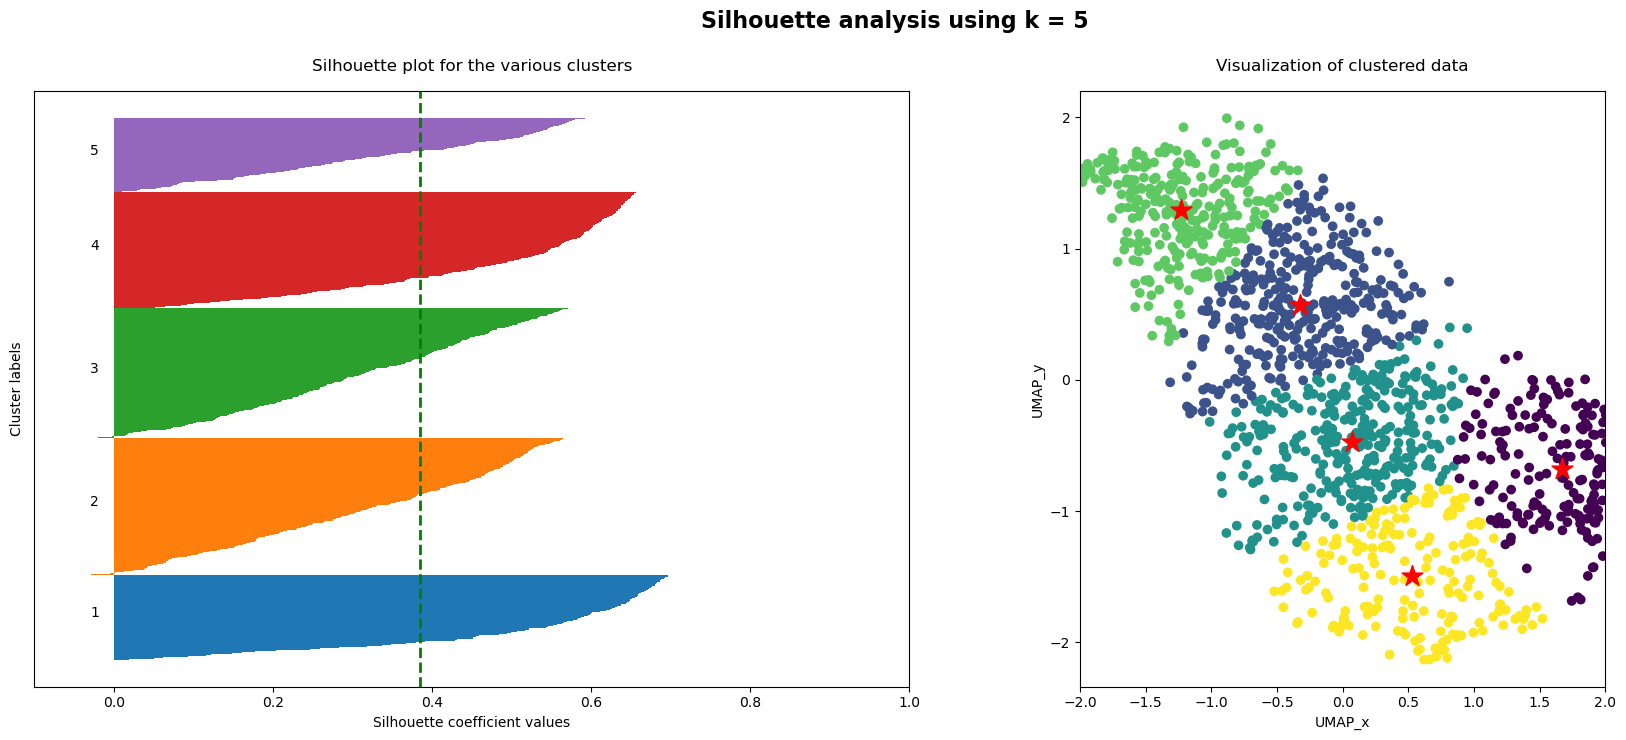

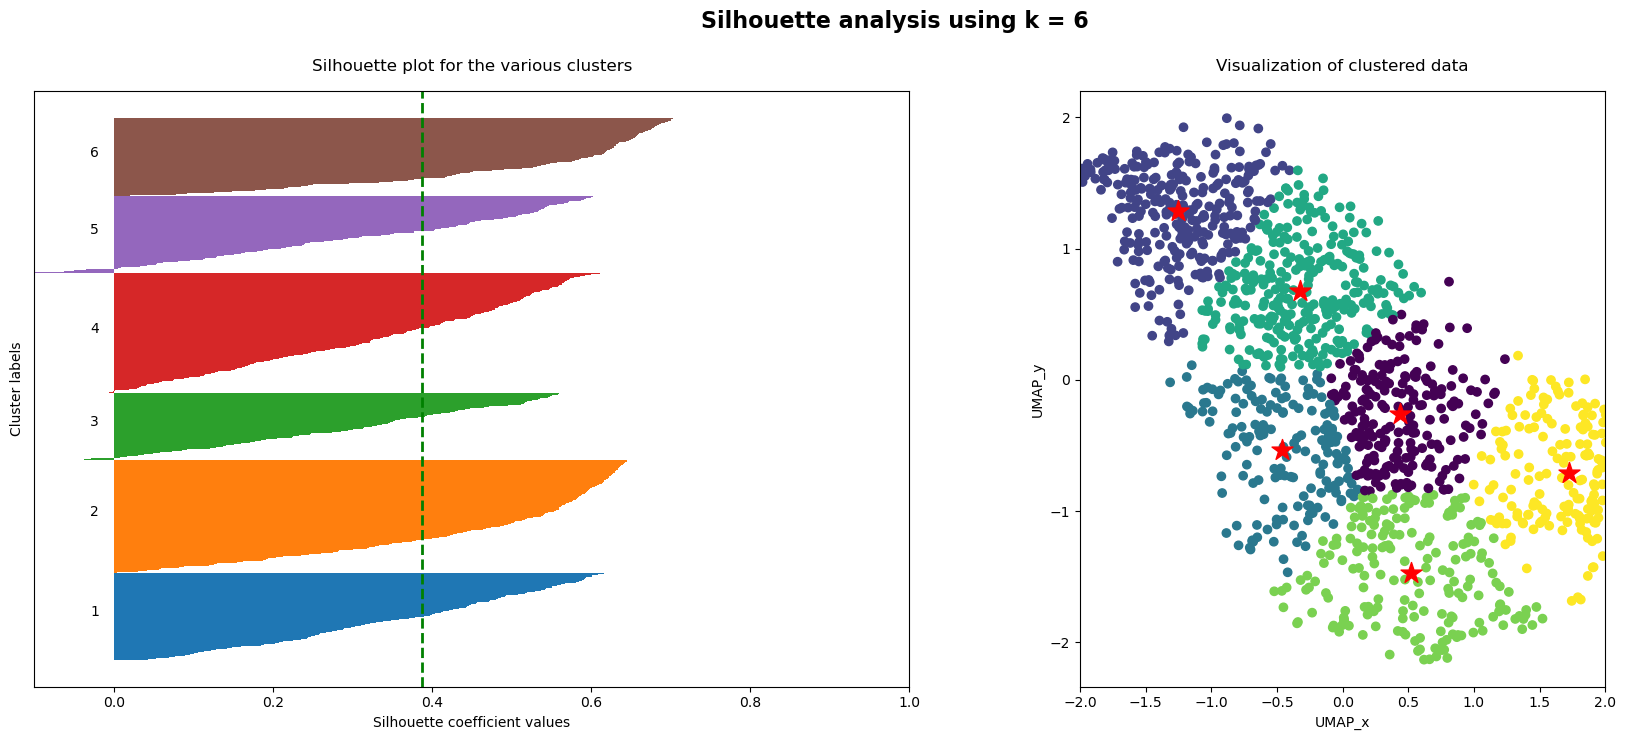

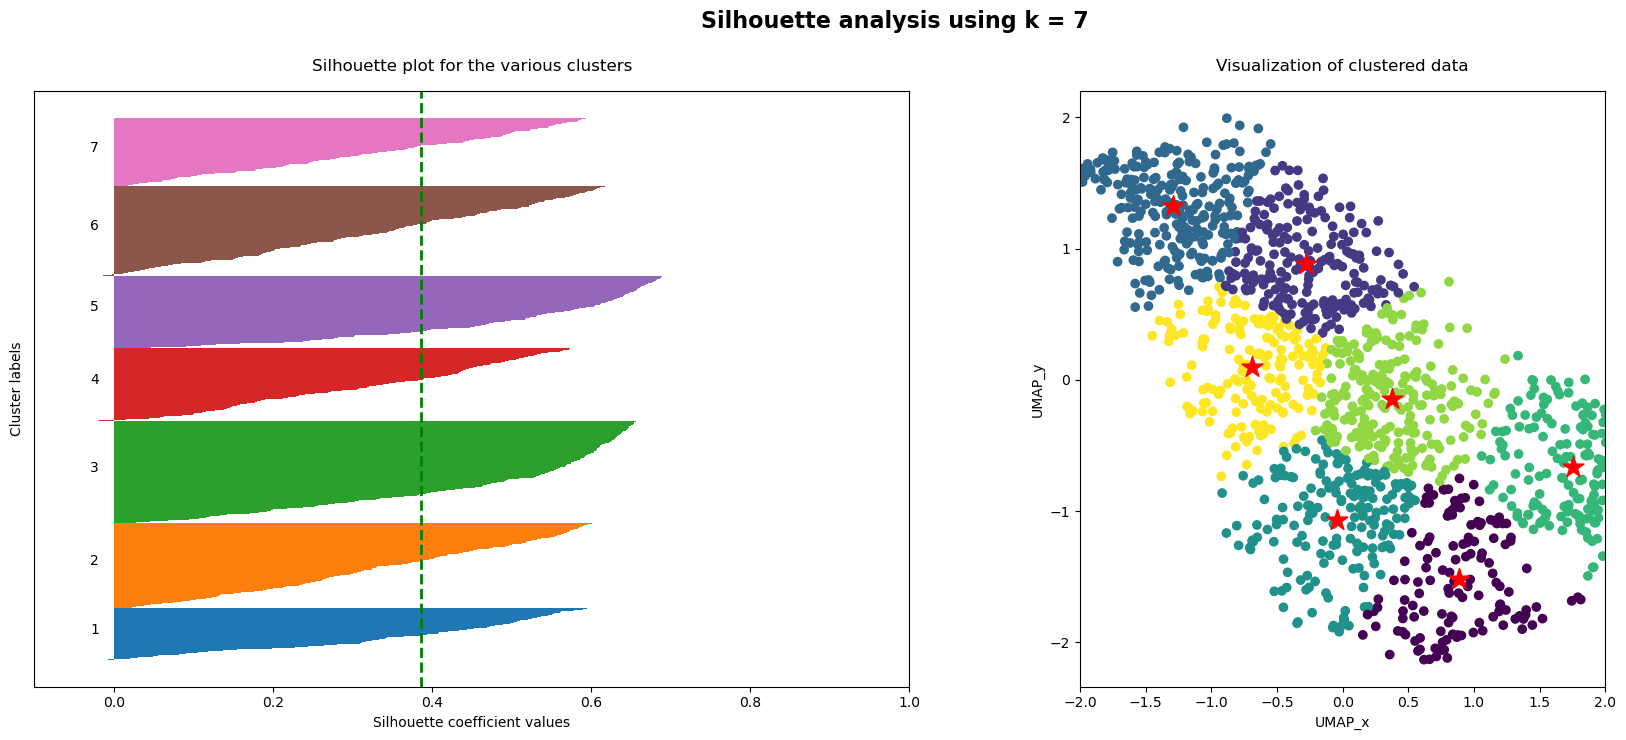

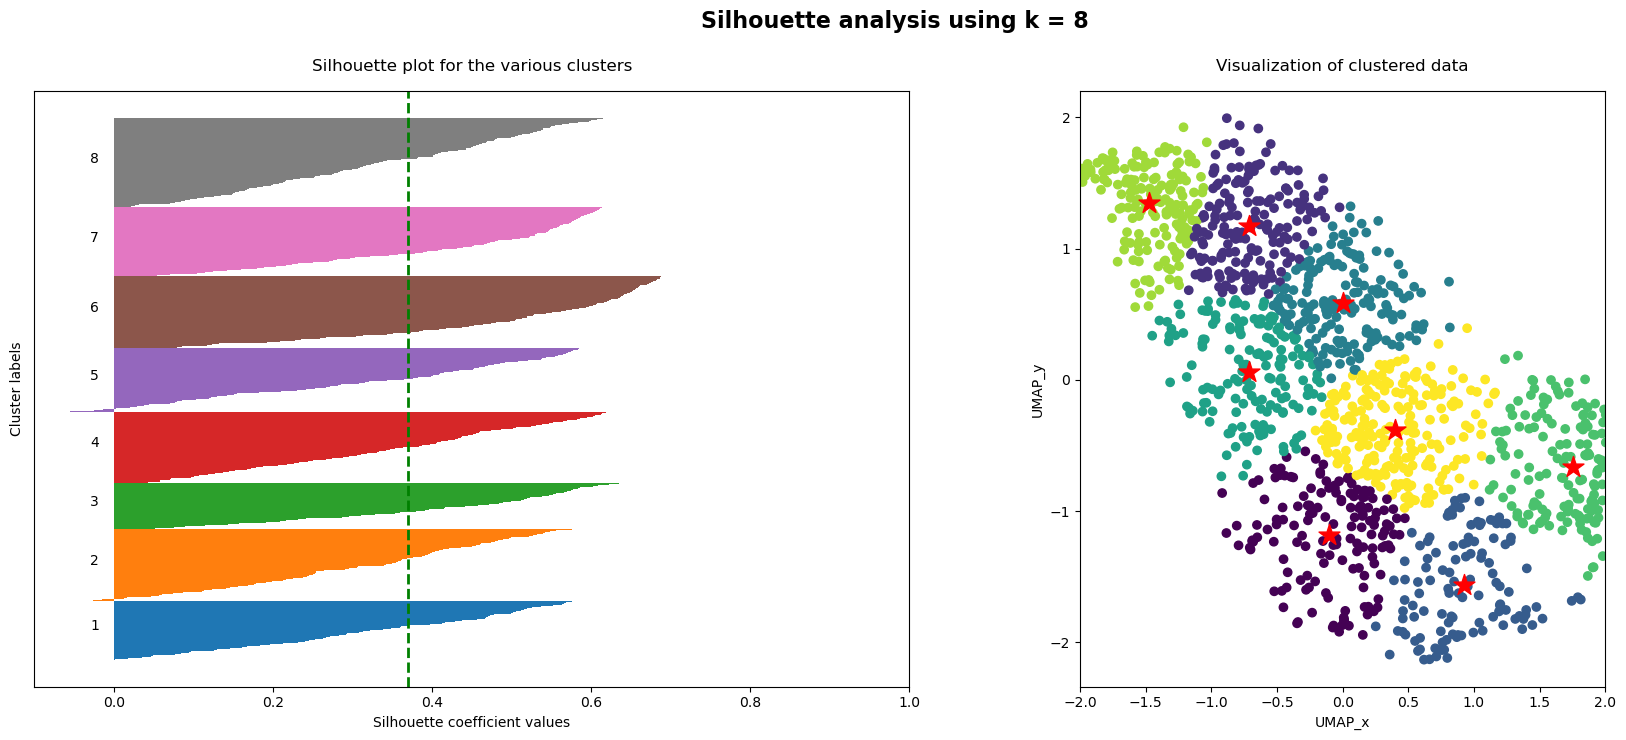

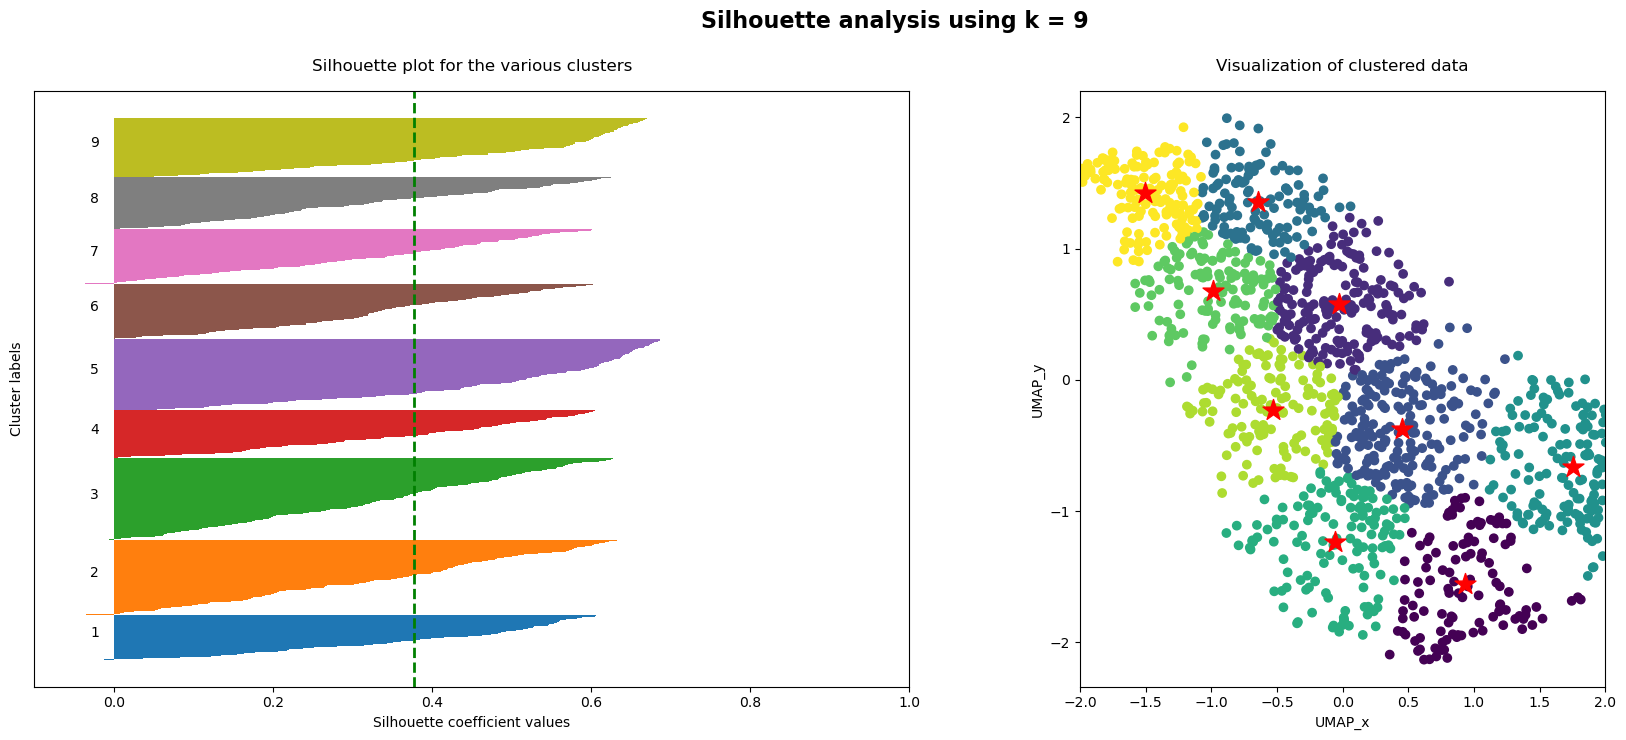

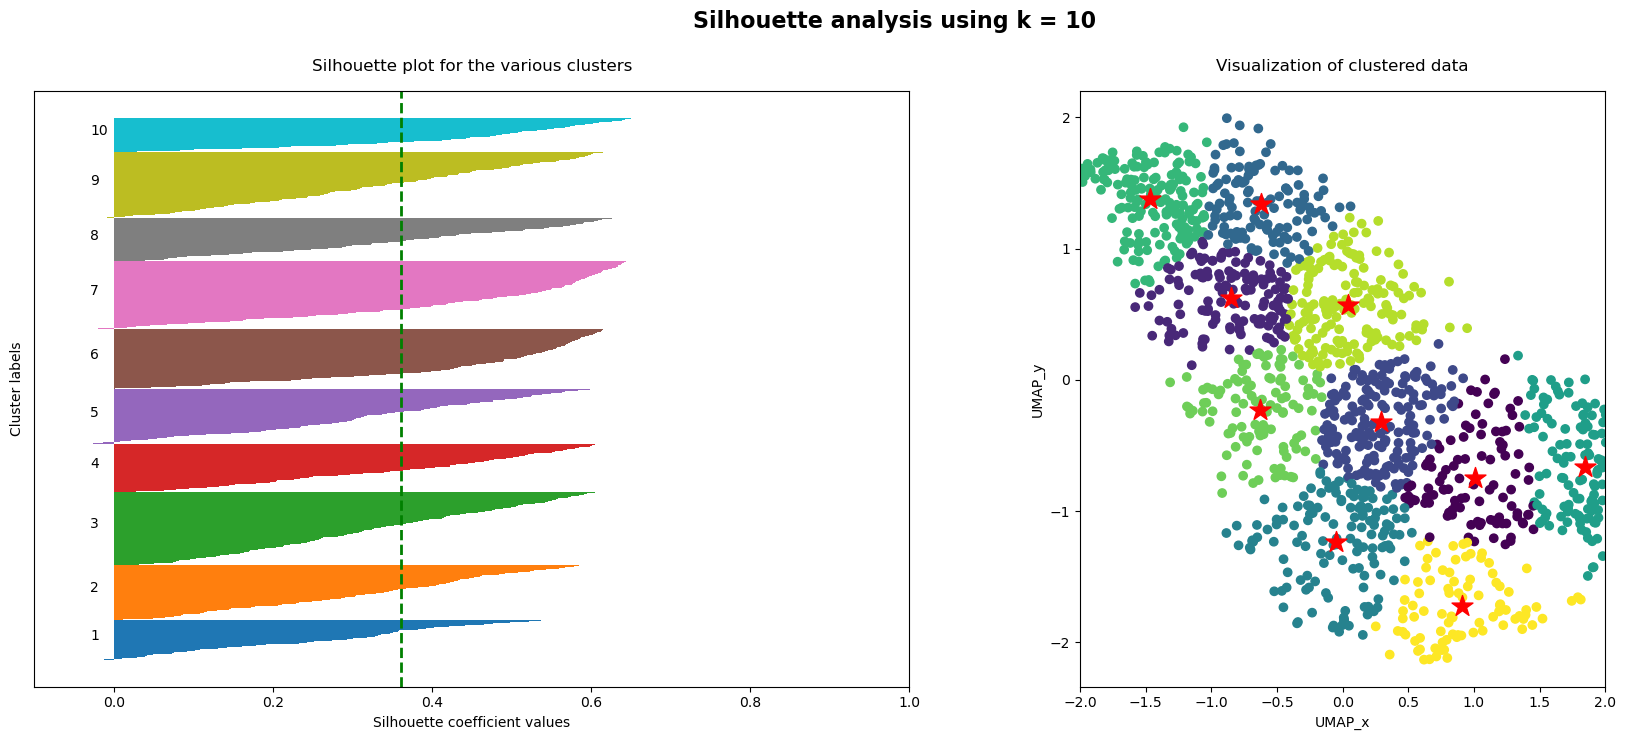

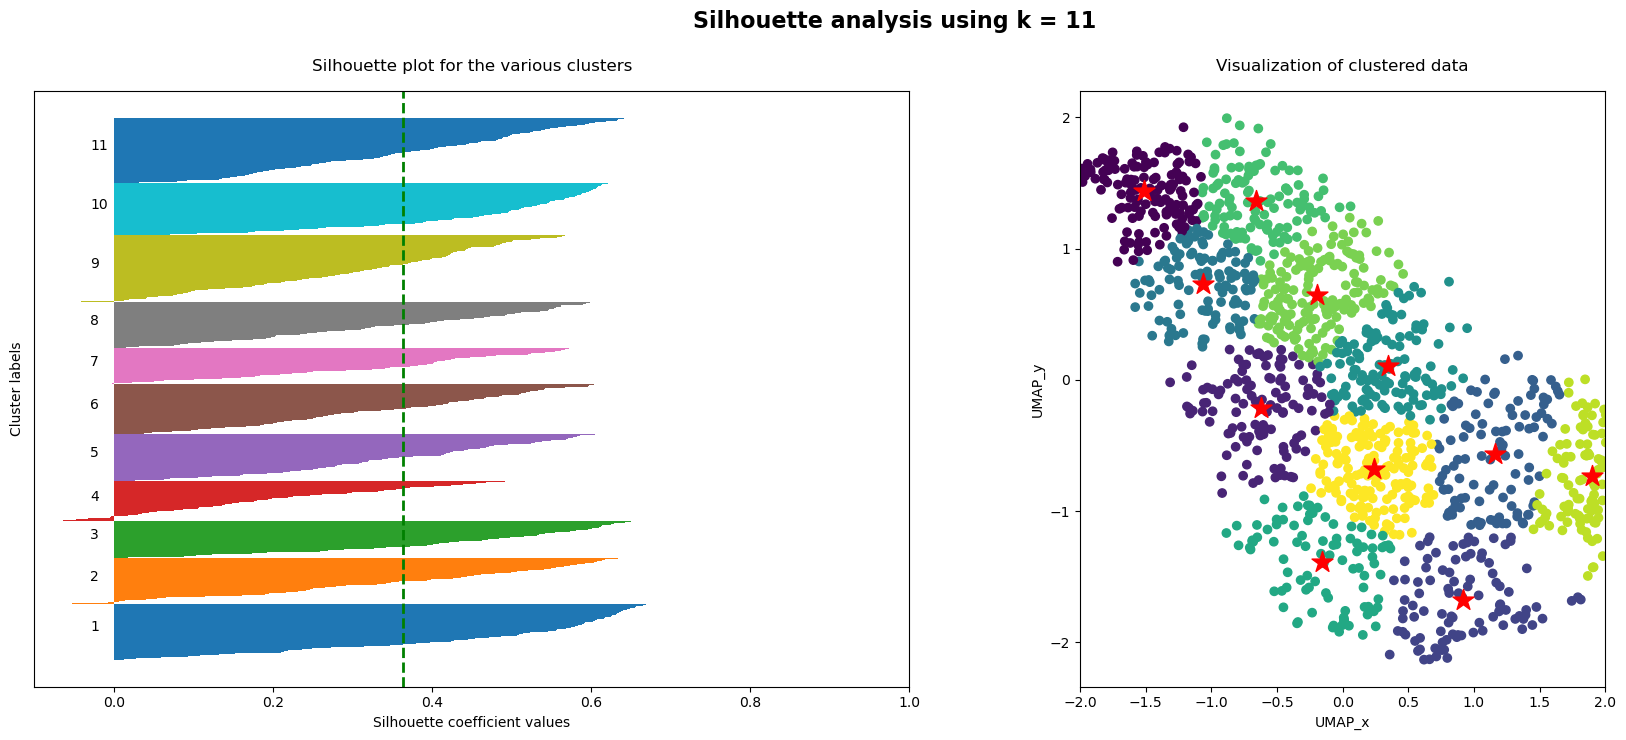

In [63]:
clust_res = k_means_umap_test(df=umap_coordinates, n_clusters_max=12, use_full=None)

Hierarchical

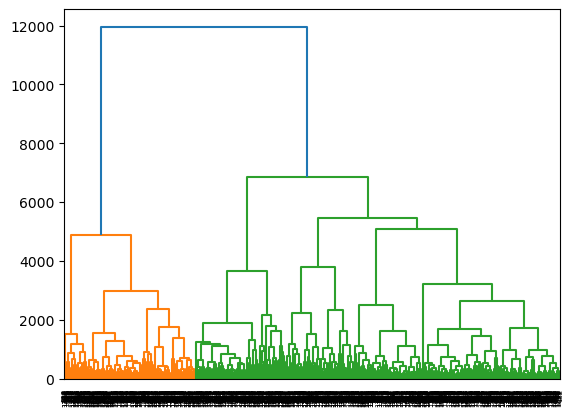

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


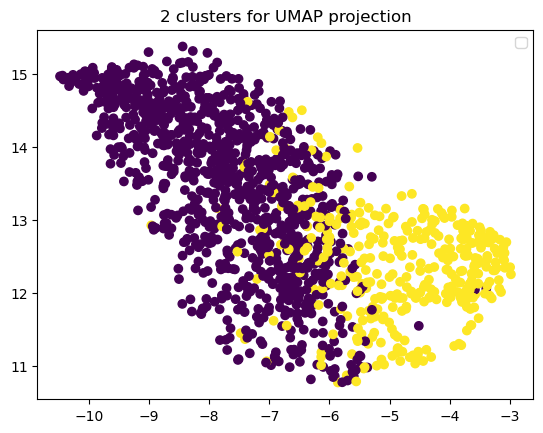

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


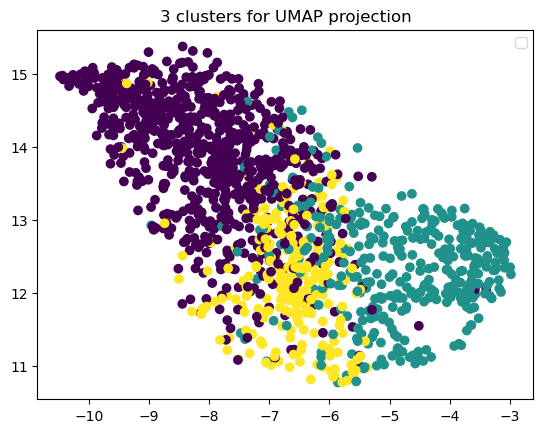

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


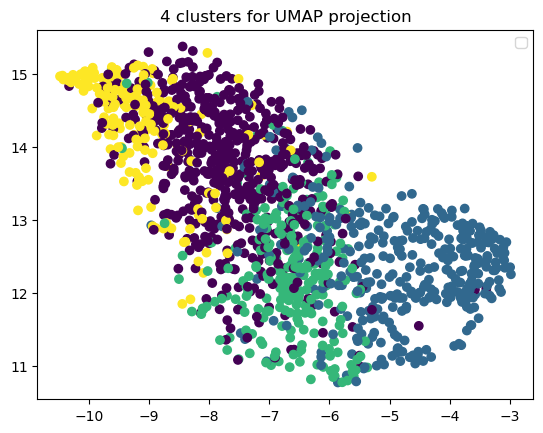

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


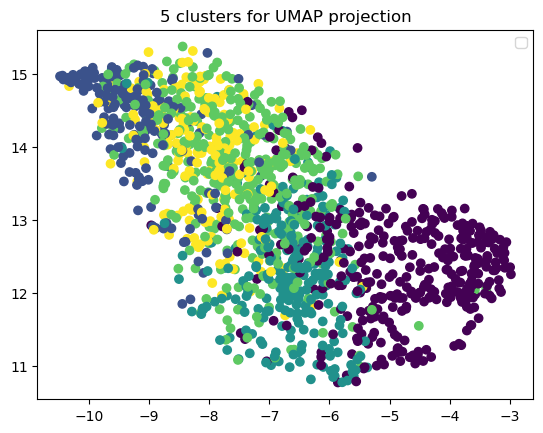

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


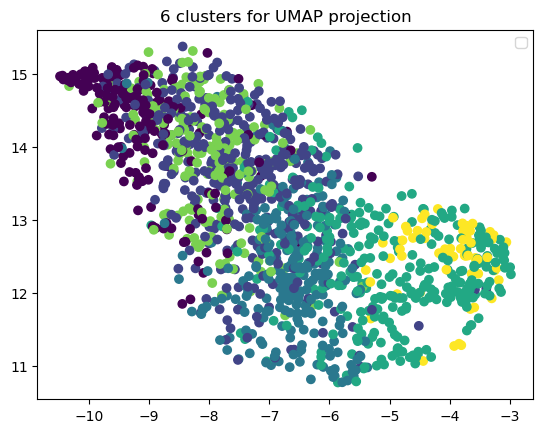

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


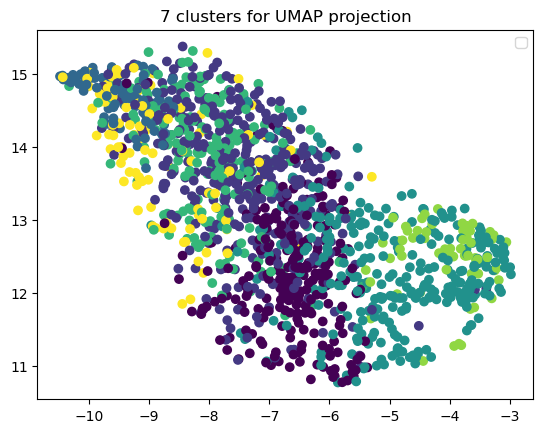

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


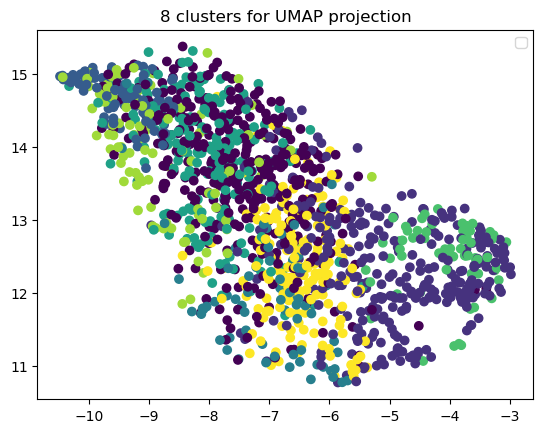

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


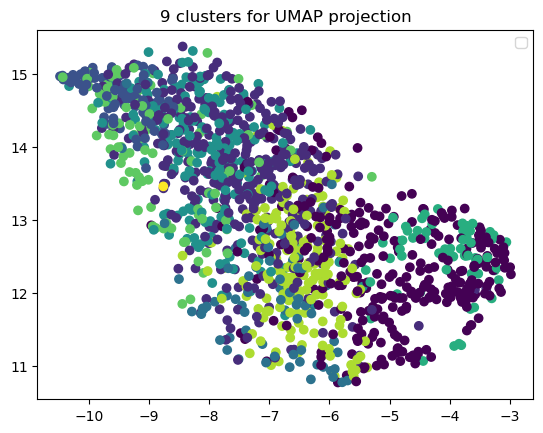

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


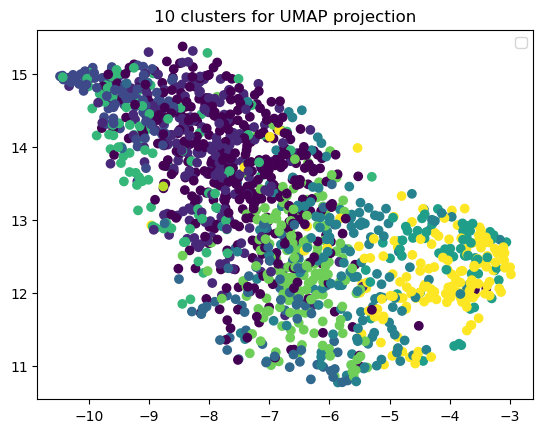

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


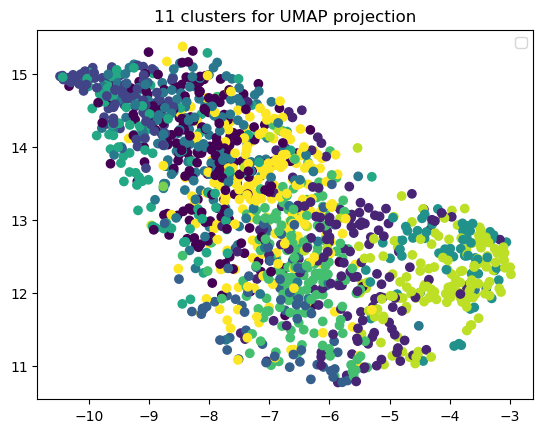

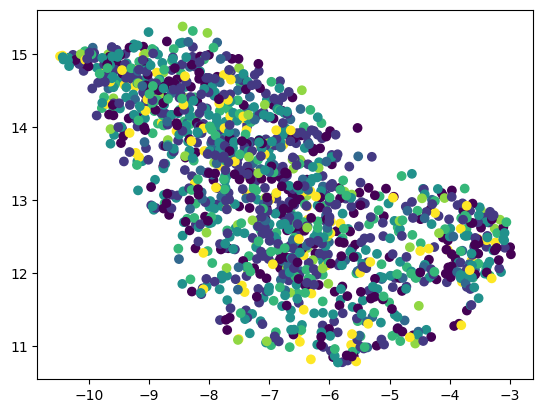

In [69]:
hier_res = set_hier(umap_coordinates, max_cluster=12, label_n_clust=7)

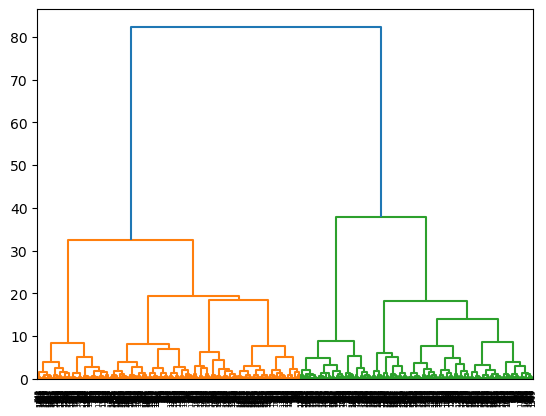

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


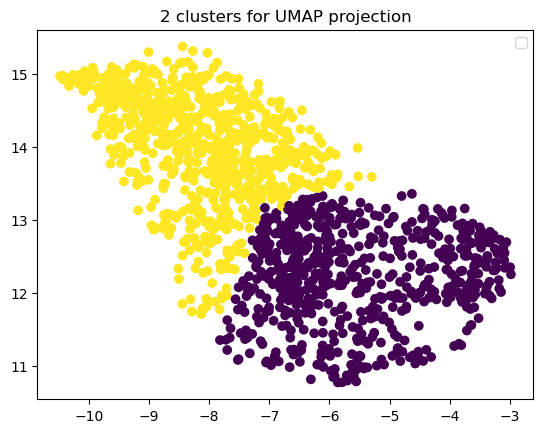

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


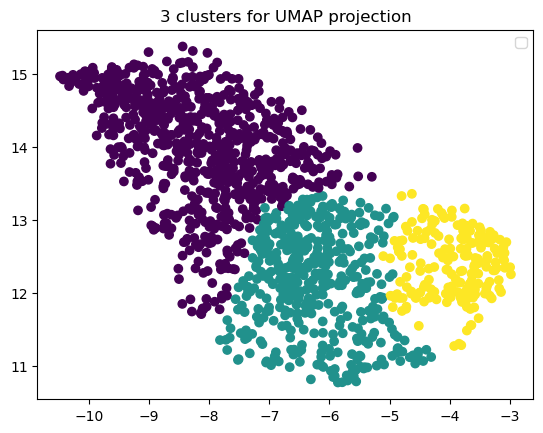

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


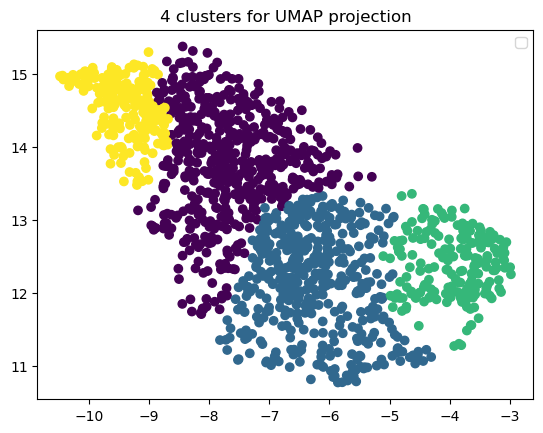

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


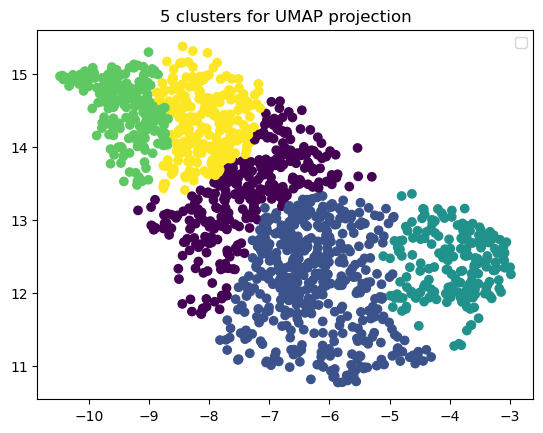

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


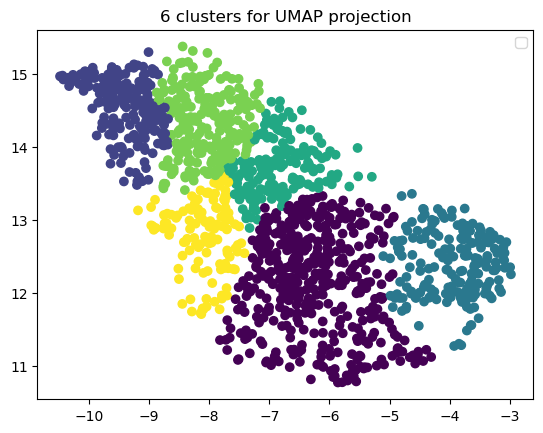

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


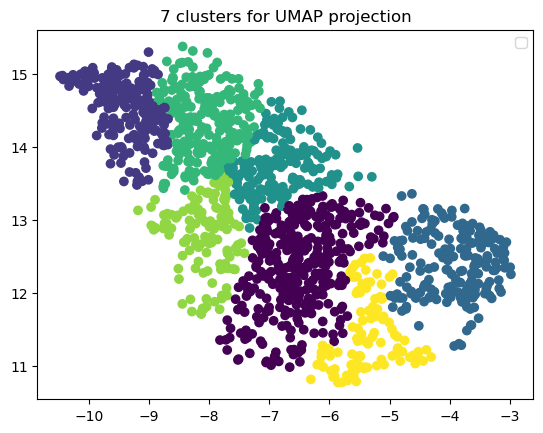

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


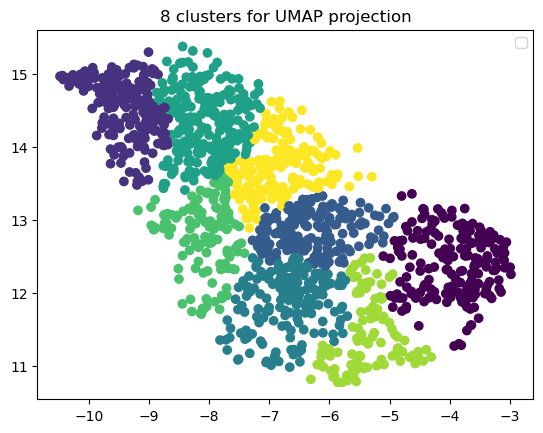

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


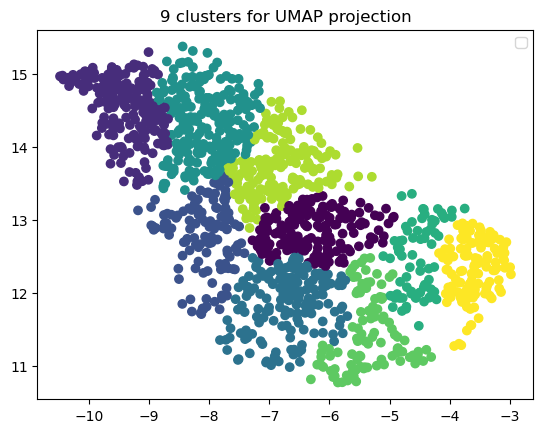

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


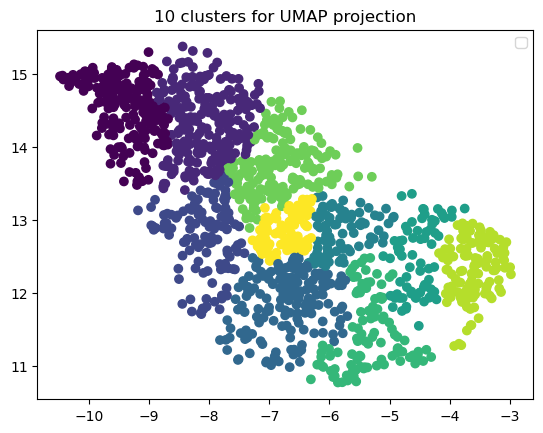

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


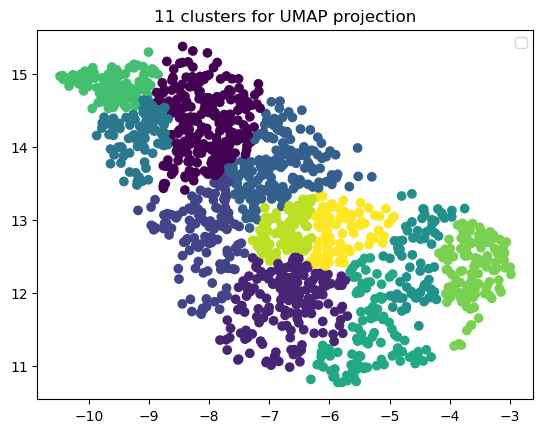

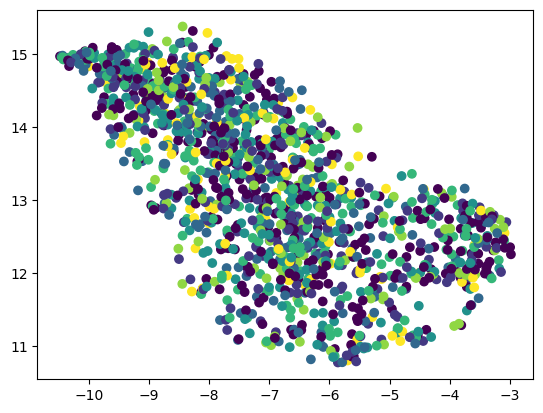

In [70]:
hier_res2 = set_hier(umap_coordinates, max_cluster=12, use_xy=1,  label_n_clust=7)

# Step 3: 3 Dimensional UMAP

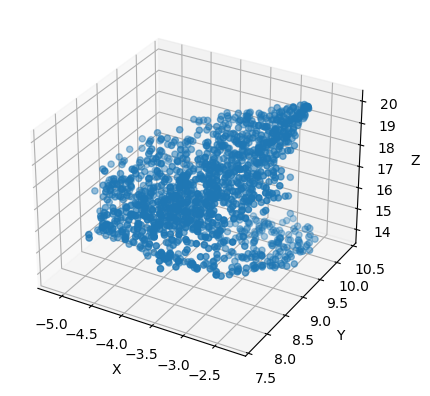

In [123]:
umap3d_df = apply_umap(n_comp=3)